# This notebook is to test the implentation of hippylib and hippyflow to solve pde and calculate the jacobian

In [1]:
import json
import ufl
import dolfin as dl
import numpy as np
import matplotlib.pyplot as plt
#sys.path.append(os.environ.get('HIPPYLIB_PATH', "../../"))
import hippylib as hp
#sys.path.append(os.environ.get('HIPPYFLOW_PATH',"../../"))
import hippyflow as hf

/home/jt925938/anaconda3/envs/gempy_dino/lib/python3.10/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):
/home/jt925938/anaconda3/envs/gempy_dino/lib/python3.10/site-packages/dolfin/jit/jit.py:46: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  if MPI.size(mpi_comm) == 1:


# Let's Define a 1D problem
$$ - \nabla \cdot(m \nabla u) =f $$
where, $$m = 1 + k x$$ 
# Weak formulation
## Let $v \in H^1_0(\Omega)$ be a test function, then find $u \in H^1(\Omega)$, such that
$$ \int_{\Omega} \nabla \cdot(m \nabla u) v d\Omega + \int_{\Omega}f v d\Omega =0$$
As we know that,  $\nabla \cdot (v m \nabla u) = \nabla \cdot(m \nabla u) v + \nabla v \cdot(m \nabla u)$
We can get, $$ \int_{\Omega} (\nabla \cdot (v m \nabla u) -\nabla v \cdot(m \nabla u))d\Omega + \int_{\Omega}f v d\Omega =0$$
$$ -\int_{\Omega} \nabla v \cdot(m \nabla u)d\Omega  +\int_{\Omega} \nabla \cdot (v m \nabla u)d\Omega + \int_{\Omega}f v d\Omega =0$$
Using the divergence rule, we can integrate over the boundary of the domain
$$ -\int_{\Omega} m \nabla u \cdot \nabla v d\Omega  +\int_{\Gamma}  v m \nabla u\cdot n d\Gamma+ \int_{\Omega}f v d\Omega =0$$
We assume that we have on Dirichlet Boundary condtion
$$ -\int_{\Omega} m \nabla u \cdot \nabla v d\Omega  +\int_{\Gamma_D}  v m \nabla u\cdot n d\Gamma_D+ \int_{\Omega}f v d\Omega =0$$
Since $v=0$ at Dirichlet BC, we can simplify the above equation as 
$$ -\int_{\Omega} m \nabla u \cdot \nabla v d\Omega  + \int_{\Omega}f v d\Omega =0$$
If there is no source term, that is $f=0$, we will get
$$ \int_{\Omega} m \nabla u \cdot \nabla v d\Omega  =0$$
## Strong solution is the weak solution
$$\frac{d}{dx}(m\frac{du}{dx}) = 0 $$
Integrating w.r.t to x and assuming $C_1$ as the integration constant
$$\frac{du}{dx} = \frac{C_1}{1+kx} $$
Integrating again w.r.t to x and assuming $C_2$ as the integration constant
$$u= \frac{C_1}{k} \ln(1+kx) + C_2 $$
Now assuming that $u(0) = 0 $ and $u(1) = 1 $ as the BC, we can get
$$u= \frac{\ln(1+kx)}{\ln(1+k)}  $$

In [2]:
nx =100 #
nodes = nx+1 # Number of nodal point
# Create an uniform interval grid of mesh points
mesh = dl.IntervalMesh(nx, dl.Constant(0.0), dl.Constant(1.0)) 
# Define Functional space for the state and parameter variable
degree = 2
Vh_STATE = dl.FunctionSpace(mesh, "CG", degree)
Vh_PARAMETER = dl.FunctionSpace(mesh, "CG", 1)
# Creat a list of Spaces for State, parameter and adjoint
Vh = [Vh_STATE, Vh_PARAMETER, Vh_STATE]
k = 2 # Para
#print(mesh.coordinates())
coord = mesh.coordinates()

m_data = 1 + k * mesh.coordinates().copy()

d2v = dl.dof_to_vertex_map(Vh[hp.PARAMETER])

v2d = dl.vertex_to_dof_map(Vh[hp.PARAMETER])

def u_boundary(x, on_boundary):
    return on_boundary and ( x[0] < dl.DOLFIN_EPS or x[0] > 1.0 - dl.DOLFIN_EPS)

u_bdr = dl.Expression("x[0]", degree=2)
u_bdr0 = dl.Constant(0.0)
bc = dl.DirichletBC(Vh[hp.STATE], u_bdr, u_boundary)
bc0 = dl.DirichletBC(Vh[hp.STATE], u_bdr0, u_boundary)

f = dl.Constant(0.0)

def pde_varf(u,m,p):
    return ufl.inner(m*ufl.grad(u), ufl.grad(p))*ufl.dx - f*p*ufl.dx

pde = hp.PDEVariationalProblem(Vh, pde_varf, bc, bc0, is_fwd_linear=True)


m = dl.Function(Vh[hp.PARAMETER])

u = dl.Function(Vh[hp.STATE])
uadj = dl.Function(Vh[hp.ADJOINT])

m_values = m_data.copy()
m.vector().set_local(m_values[d2v]) #uncomment this

x = [u.vector(),m.vector(),uadj.vector()]
pde.solveFwd(x[hp.STATE], x)

u_data = x[hp.STATE].get_local()



/tmp/jt925938/login23-g-1_109249/ipykernel_137443/546936476.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m.vector().set_local(m_values[d2v]) #uncomment this


In [3]:
u_trial = dl.TrialFunction(Vh[hp.STATE])
u_test = dl.TestFunction(Vh[hp.STATE])
M = dl.PETScMatrix()
M_U = dl.assemble(dl.inner(u_trial,u_test)*dl.dx)

I_U = hf.StateSpaceIdentityOperator(M_U)
#observable = hf.LinearStateObservable(pde,M_U)
observable = hf.LinearStateObservable(pde,I_U)

Jm = hf.ObservableJacobian(observable)

m_trial = dl.TrialFunction(Vh[hp.PARAMETER])
m_test = dl.TestFunction(Vh[hp.PARAMETER])

M_M = dl.assemble(dl.inner(m_trial,m_test)*dl.dx)

In [4]:
u_true = np.log(m_data)/np.log(1+k)
type(u_true), u_true.shape #, u_pde.shape

(numpy.ndarray, (101, 1))

In [5]:
d2v

array([100,  99,  98,  97,  96,  95,  94,  93,  92,  91,  90,  89,  88,
        87,  86,  85,  84,  83,  82,  81,  80,  79,  78,  77,  76,  75,
        74,  73,  72,  71,  70,  69,  68,  67,  66,  65,  64,  63,  62,
        61,  60,  59,  58,  57,  56,  55,  54,  53,  52,  51,  50,  49,
        48,  47,  46,  45,  44,  43,  42,  41,  40,  39,  38,  37,  36,
        35,  34,  33,  32,  31,  30,  29,  28,  27,  26,  25,  24,  23,
        22,  21,  20,  19,  18,  17,  16,  15,  14,  13,  12,  11,  10,
         9,   8,   7,   6,   5,   4,   3,   2,   1,   0], dtype=uint64)

In [6]:
global_indices = mesh.topology().global_indices(0)  
# the points associated with the DOFs of the CG2 space.
dof_coordinates = Vh[hp.STATE].tabulate_dof_coordinates()
# print("mesh Coordinates :")
# print(mesh.coordinates())
# print("Coordinates of CG2 nodes:")
# print(dof_coordinates)
N =dof_coordinates.shape[0]
print(N)

201


In [7]:
cg2 = list(range(N-degree, -1, -degree))
if cg2[-1]!=0:
    cg2.append(0)
print(cg2)
u_pde = u_data[cg2]

[199, 197, 195, 193, 191, 189, 187, 185, 183, 181, 179, 177, 175, 173, 171, 169, 167, 165, 163, 161, 159, 157, 155, 153, 151, 149, 147, 145, 143, 141, 139, 137, 135, 133, 131, 129, 127, 125, 123, 121, 119, 117, 115, 113, 111, 109, 107, 105, 103, 101, 99, 97, 95, 93, 91, 89, 87, 85, 83, 81, 79, 77, 75, 73, 71, 69, 67, 65, 63, 61, 59, 57, 55, 53, 51, 49, 47, 45, 43, 41, 39, 37, 35, 33, 31, 29, 27, 25, 23, 21, 19, 17, 15, 13, 11, 9, 7, 5, 3, 1, 0]


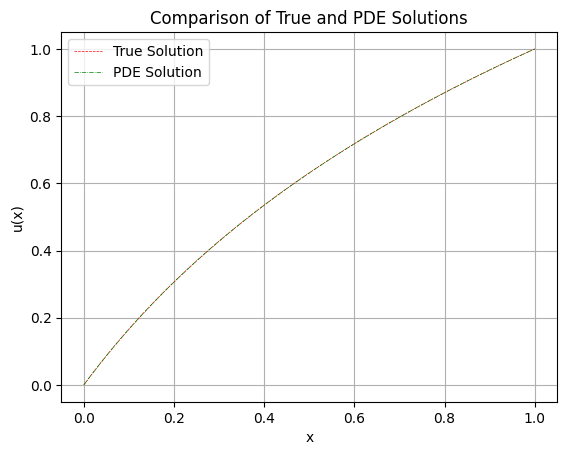

In [8]:
plt.plot(coord, u_true, 'r--',linewidth=0.5, label='True Solution')   # red, dashed, circles
plt.plot(coord, u_pde, 'g-.',linewidth=0.5,label='PDE Solution')      # blue, solid, squares

plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Comparison of True and PDE Solutions")
plt.legend()
plt.grid(True)
plt.show()

In [9]:

dU = u.vector().get_local()[cg2].shape[0]
dM = m.vector().get_local().shape[0]
# once you have modified the means of c->m(c) comment this
print(dU, dM)
uhat = dl.Function(Vh[hp.STATE])
m_nodes_hat = dl.Function(Vh[hp.PARAMETER])
m_nodes_hat_ = dl.Function(Vh[hp.PARAMETER])
Jm_data = np.zeros((dU, dM))
m_values = m_data.copy()
Jm.observable.setLinearizationPoint(x)
# observable.setLinearizationPoint(x)
# Jm = hf.ObservableJacobian(observable)
print(Jm)
for component in range(dM):
    m_hat = np.zeros((dM))
    m_hat[component] = 1
    m_nodes_hat.vector().set_local(m_hat[v2d]) 
    #m_nodes_hat.vector().set_local(M_M.array()[:,component][v2d]) 
    # M_M.mult(m_nodes_hat.vector(), m_nodes_hat_.vector())
    # Jm.mult(m_nodes_hat_.vector(), uhat.vector()) 
    Jm.mult(m_nodes_hat.vector(), uhat.vector()) 
    Jm_data[:,component] = uhat.vector().get_local()[cg2]
#Jm_data

101 101


# We need to test if du/dm is correct or not

In [10]:
def test_jacobian(m_data_, u_true,  J_true, epsilon):
    m = dl.Function(Vh[hp.PARAMETER])
    u = dl.Function(Vh[hp.STATE])
    uadj = dl.Function(Vh[hp.ADJOINT])
    dU = u.vector().get_local().shape[0]
    dM = m.vector().get_local().shape[0]
    error_total = 0
    error_div_u =0
    # print("J_true\n", J_true)
    for i in range(dM):
        m = dl.Function(Vh[hp.PARAMETER])
        u = dl.Function(Vh[hp.STATE])
        uadj = dl.Function(Vh[hp.ADJOINT])
        m_values_ = m_data_.copy()
        m_values_[i] = m_values_[i] + epsilon
        m.vector().set_local(m_values_[d2v]) #uncomment this
        
        x = [u.vector(),m.vector(),uadj.vector()]
        pde.solveFwd(x[hp.STATE], x)

        u_data_current = x[hp.STATE].get_local()[cg2]
        delta_u  = u_data_current - u_true
        error_div_u = error_div_u + np.linalg.norm(delta_u)
        #print(delta_u)
        Jm_FD_i = (u_data_current - u_true)/epsilon
        # print(Jm_FD_i)
        error = np.linalg.norm(Jm_FD_i - J_true[:,i])
        error_total = error_total + error
    # error_total = np.linalg.norm(delta_u)
    return error_total ,error_div_u
        
        
    
epsilon_data = [1e-10, 1e-9, 1e-8, 1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
#epsilon_data = [1e-8]
error_data =[]
error_div_u = []
for eps in epsilon_data:
    #test_jacobian(m_data_=m_data, u_true=u_pde,  J_true=Jm_data, epsilon=eps)
    rms, err = test_jacobian(m_data_=m_data, u_true=u_pde,  J_true=Jm_data, epsilon=eps)
    error_data.append(rms)
    error_div_u.append(err)

/tmp/jt925938/login23-g-1_109249/ipykernel_137443/2717073268.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m.vector().set_local(m_values_[d2v]) #uncomment this


In [11]:
epsilon_data , error_data

([1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1],
 [0.11832079255569662,
  0.012714334457504224,
  0.0010526469198186507,
  0.0001227570821154675,
  1.266580262917537e-05,
  1.061196107626113e-05,
  0.00010190006833689922,
  0.0010182816617784099,
  0.010133467849654213,
  0.09667842458339798])

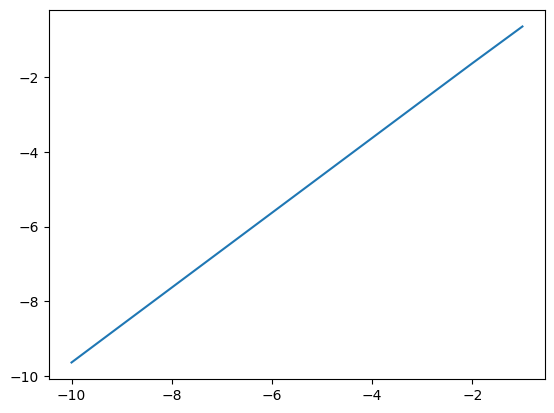

In [12]:
plt.plot(np.log10(epsilon_data), np.log10(error_div_u)) 

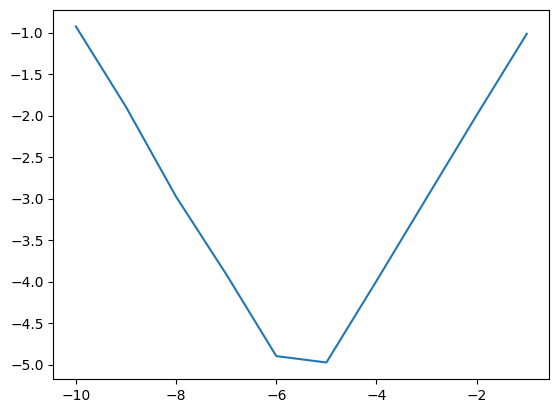

In [13]:
plt.plot(np.log10(epsilon_data), np.log10(error_data)) 

# We need to test with Jacobian w.r.t to k 
$$m = 1 + k x$$
$$R(u,m) = 0$$
$$\frac{du}{dk} = \frac{du}{dm} \frac{dm}{dk}$$

In [14]:
nx =1000 #
nodes = nx+1 # Number of nodal point
# Create an uniform interval grid of mesh points
mesh = dl.IntervalMesh(nx, dl.Constant(0.0), dl.Constant(1.0)) 
# Define Functional space for the state and parameter variable
degree = 2
Vh_STATE = dl.FunctionSpace(mesh, "CG", degree)
Vh_PARAMETER = dl.FunctionSpace(mesh, "CG", 1)
# Creat a list of Spaces for State, parameter and adjoint
Vh = [Vh_STATE, Vh_PARAMETER, Vh_STATE]
k = 2 # Para
#print(mesh.coordinates())
coord = mesh.coordinates()

m_data = 1 + k * mesh.coordinates().copy()
dm_dk  = mesh.coordinates().copy()
print("dm_dk\n", dm_dk)
d2v = dl.dof_to_vertex_map(Vh[hp.PARAMETER])

v2d = dl.vertex_to_dof_map(Vh[hp.PARAMETER])

def u_boundary(x, on_boundary):
    return on_boundary and ( x[0] < dl.DOLFIN_EPS or x[0] > 1.0 - dl.DOLFIN_EPS)

u_bdr = dl.Expression("x[0]", degree=2)
u_bdr0 = dl.Constant(0.0)
bc = dl.DirichletBC(Vh[hp.STATE], u_bdr, u_boundary)
bc0 = dl.DirichletBC(Vh[hp.STATE], u_bdr0, u_boundary)

f = dl.Constant(0.0)

def pde_varf(u,m,p):
    return ufl.inner(m*ufl.grad(u), ufl.grad(p))*ufl.dx - f*p*ufl.dx

pde = hp.PDEVariationalProblem(Vh, pde_varf, bc, bc0, is_fwd_linear=True)


m = dl.Function(Vh[hp.PARAMETER])

u = dl.Function(Vh[hp.STATE])
uadj = dl.Function(Vh[hp.ADJOINT])

m_values = m_data.copy()
m.vector().set_local(m_values[d2v]) #uncomment this

x = [u.vector(),m.vector(),uadj.vector()]
pde.solveFwd(x[hp.STATE], x)

u_data = x[hp.STATE].get_local()

u_trial = dl.TrialFunction(Vh[hp.STATE])
u_test = dl.TestFunction(Vh[hp.STATE])
M = dl.PETScMatrix()
M_U = dl.assemble(dl.inner(u_trial,u_test)*dl.dx)

I_U = hf.StateSpaceIdentityOperator(M_U)
#observable = hf.LinearStateObservable(pde,M_U)
observable = hf.LinearStateObservable(pde,I_U)

Jm2 = hf.ObservableJacobian(observable)

m_trial = dl.TrialFunction(Vh[hp.PARAMETER])
m_test = dl.TestFunction(Vh[hp.PARAMETER])

M_M = dl.assemble(dl.inner(m_trial,m_test)*dl.dx)

global_indices = mesh.topology().global_indices(0)  
# the points associated with the DOFs of the CG2 space.
dof_coordinates = Vh[hp.STATE].tabulate_dof_coordinates()
N =dof_coordinates.shape[0]
cg2 = list(range(N-degree, -1, -degree))
if cg2[-1]!=0:
    cg2.append(0)
u_pde = u_data[cg2]

dU = u.vector().get_local()[cg2].shape[0]
dM = m.vector().get_local().shape[0]
# once you have modified the means of c->m(c) comment this

uhat = dl.Function(Vh[hp.STATE])
m_nodes_hat = dl.Function(Vh[hp.PARAMETER])
m_nodes_hat_ = dl.Function(Vh[hp.PARAMETER])
Jm_data2 = np.zeros((dU))
m_values = m_data.copy()
Jm2.observable.setLinearizationPoint(x)
m_nodes_hat.vector().set_local(dm_dk[v2d]) 
#m_nodes_hat.vector().set_local(M_M.array()[:,component][v2d]) 
#M_M.mult(m_nodes_hat.vector(), m_nodes_hat_.vector())
#Jm2.mult(m_nodes_hat_.vector(), uhat.vector()) 
Jm2.mult(m_nodes_hat.vector(), uhat.vector()) 
Jm_data2 = uhat.vector().get_local()[cg2]

dm_dk
 [[0.   ]
 [0.001]
 [0.002]
 ...
 [0.998]
 [0.999]
 [1.   ]]


/tmp/jt925938/login23-g-1_109249/ipykernel_137443/4197839711.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m.vector().set_local(m_values[d2v]) #uncomment this
/tmp/jt925938/login23-g-1_109249/ipykernel_137443/4197839711.py:86: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m_nodes_hat.vector().set_local(dm_dk[v2d])


In [15]:
Jm_data2

array([-0.00000000e+00,  3.56617037e-04,  7.10715172e-04, ...,
        1.65938244e-04,  8.29752271e-05, -0.00000000e+00])

In [16]:
def test_jacobian(k_data, u_true,  J_true, epsilon):
    m = dl.Function(Vh[hp.PARAMETER])
    u = dl.Function(Vh[hp.STATE])
    uadj = dl.Function(Vh[hp.ADJOINT])
    dU = u.vector().get_local().shape[0]
    dM = m.vector().get_local().shape[0]
    error_total = 0
    error_div_u =0
    # print("J_true\n", J_true)
    m = dl.Function(Vh[hp.PARAMETER])
    u = dl.Function(Vh[hp.STATE])
    uadj = dl.Function(Vh[hp.ADJOINT])
    
    m_values_ = 1 + (k_data +epsilon) * mesh.coordinates().copy()
    m.vector().set_local(m_values_[d2v]) #uncomment this
    
    x = [u.vector(),m.vector(),uadj.vector()]
    pde.solveFwd(x[hp.STATE], x)

    u_data_current = x[hp.STATE].get_local()[cg2]
    delta_u  = u_data_current - u_true
    error_div_u = error_div_u + np.linalg.norm(delta_u)
    #print(delta_u)
    Jm_FD_i = (u_data_current - u_true)/epsilon
    # print(Jm_FD_i)
    error = np.linalg.norm(Jm_FD_i - J_true)
    error_total = error_total + error
    # error_total = np.linalg.norm(delta_u)
    return error_total ,error_div_u
        
        
    
epsilon_data = [1e-10, 1e-9, 1e-8, 1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
#epsilon_data = [1e-8]
error_data =[]
error_div_u = []
for eps in epsilon_data:
    #test_jacobian(m_data_=m_data, u_true=u_pde,  J_true=Jm_data, epsilon=eps)
    rms, err = test_jacobian(k_data=k, u_true=u_pde,  J_true=Jm_data2, epsilon=eps)
    error_data.append(rms)
    error_div_u.append(err)

/tmp/jt925938/login23-g-1_109249/ipykernel_137443/91403075.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m.vector().set_local(m_values_[d2v]) #uncomment this


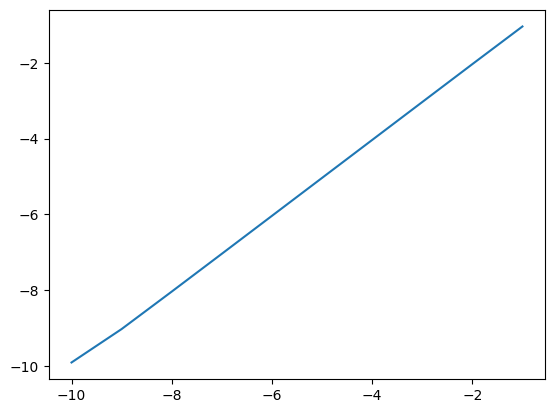

In [17]:
plt.plot(np.log10(epsilon_data), np.log10(error_div_u)) 

/tmp/jt925938/login23-g-1_109249/ipykernel_137443/3722972882.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


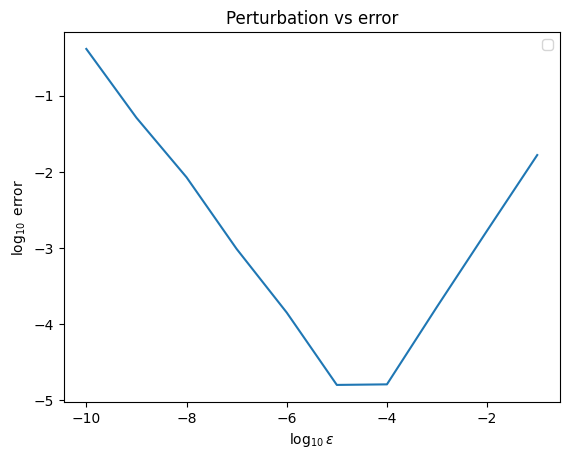

In [18]:
plt.plot(np.log10(epsilon_data), np.log10(error_data)) 
plt.xlabel("$\log_{10} \epsilon$")
plt.ylabel("$\log_{10}$ error")
plt.title("Perturbation vs error")
plt.legend()
plt.show()

# Trying to verify the result if the paramter of PDE, m is dependent on a vecotor input
$$m = k_1 + k_2 x$$

In [19]:
nx =1000 #
nodes = nx+1 # Number of nodal point
# Create an uniform interval grid of mesh points
mesh = dl.IntervalMesh(nx, dl.Constant(0.0), dl.Constant(1.0)) 
# Define Functional space for the state and parameter variable
degree = 2
Vh_STATE = dl.FunctionSpace(mesh, "CG", degree)
Vh_PARAMETER = dl.FunctionSpace(mesh, "CG", 1)
# Creat a list of Spaces for State, parameter and adjoint
Vh = [Vh_STATE, Vh_PARAMETER, Vh_STATE]
k = [1,2] # Para
#print(mesh.coordinates())
coord = mesh.coordinates()

m_data = k[0] + k[1] * mesh.coordinates().copy()
dm_dk = np.zeros((nodes, len(k)))
dm_dk[:,0]  = np.ones(nodes)
dm_dk[:,1]  = coord[:,0]
#print("dm_dk\n", dm_dk)
d2v = dl.dof_to_vertex_map(Vh[hp.PARAMETER])

v2d = dl.vertex_to_dof_map(Vh[hp.PARAMETER])

def u_boundary(x, on_boundary):
    return on_boundary and ( x[0] < dl.DOLFIN_EPS or x[0] > 1.0 - dl.DOLFIN_EPS)

u_bdr = dl.Expression("x[0]", degree=2)
u_bdr0 = dl.Constant(0.0)
bc = dl.DirichletBC(Vh[hp.STATE], u_bdr, u_boundary)
bc0 = dl.DirichletBC(Vh[hp.STATE], u_bdr0, u_boundary)

f = dl.Constant(0.0)

def pde_varf(u,m,p):
    return ufl.inner(m*ufl.grad(u), ufl.grad(p))*ufl.dx - f*p*ufl.dx

pde = hp.PDEVariationalProblem(Vh, pde_varf, bc, bc0, is_fwd_linear=True)


m = dl.Function(Vh[hp.PARAMETER])

u = dl.Function(Vh[hp.STATE])
uadj = dl.Function(Vh[hp.ADJOINT])

m_values = m_data.copy()
m.vector().set_local(m_values[d2v]) #uncomment this

x = [u.vector(),m.vector(),uadj.vector()]
pde.solveFwd(x[hp.STATE], x)

u_data = x[hp.STATE].get_local()

u_trial = dl.TrialFunction(Vh[hp.STATE])
u_test = dl.TestFunction(Vh[hp.STATE])
M = dl.PETScMatrix()
M_U = dl.assemble(dl.inner(u_trial,u_test)*dl.dx)

I_U = hf.StateSpaceIdentityOperator(M_U)
#observable = hf.LinearStateObservable(pde,M_U)
observable = hf.LinearStateObservable(pde,I_U)

Jm3 = hf.ObservableJacobian(observable)

m_trial = dl.TrialFunction(Vh[hp.PARAMETER])
m_test = dl.TestFunction(Vh[hp.PARAMETER])

M_M = dl.assemble(dl.inner(m_trial,m_test)*dl.dx)

global_indices = mesh.topology().global_indices(0)  
# the points associated with the DOFs of the CG2 space.
dof_coordinates = Vh[hp.STATE].tabulate_dof_coordinates()
N =dof_coordinates.shape[0]
cg2 = list(range(N-degree, -1, -degree))
if cg2[-1]!=0:
    cg2.append(0)
u_pde = u_data[cg2]

dU = u.vector().get_local()[cg2].shape[0]
dK = len(k)
dM = m.vector().get_local().shape[0]
# once you have modified the means of c->m(c) comment this

uhat = dl.Function(Vh[hp.STATE])
m_nodes_hat = dl.Function(Vh[hp.PARAMETER])
m_nodes_hat_ = dl.Function(Vh[hp.PARAMETER])
Jm_data3 = np.zeros((dU,dK))
m_values = m_data.copy()
Jm3.observable.setLinearizationPoint(x)
m_nodes_hat.vector().set_local(dm_dk[:,0][v2d]) 
Jm2.mult(m_nodes_hat.vector(), uhat.vector()) 
Jm_data3[:,0] = uhat.vector().get_local()[cg2]
m_nodes_hat.vector().set_local(dm_dk[:,1][v2d]) 
Jm2.mult(m_nodes_hat.vector(), uhat.vector()) 
Jm_data3[:,1] = uhat.vector().get_local()[cg2]
Jm_data3

/tmp/jt925938/login23-g-1_109249/ipykernel_137443/187739430.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m.vector().set_local(m_values[d2v]) #uncomment this


array([[-0.00000000e+00, -0.00000000e+00],
       [-7.13234074e-04,  3.56617037e-04],
       [-1.42143034e-03,  7.10715172e-04],
       ...,
       [-3.31876488e-04,  1.65938244e-04],
       [-1.65950454e-04,  8.29752271e-05],
       [-0.00000000e+00, -0.00000000e+00]])

In [20]:
def test_jacobian(k_data, u_true,  J_true, epsilon):
    m = dl.Function(Vh[hp.PARAMETER])
    u = dl.Function(Vh[hp.STATE])
    uadj = dl.Function(Vh[hp.ADJOINT])
    dU = u.vector().get_local().shape[0]
    dM = m.vector().get_local().shape[0]
    error_total = 0
    error_div_u =0
    # print("J_true\n", J_true)
    m = dl.Function(Vh[hp.PARAMETER])
    u = dl.Function(Vh[hp.STATE])
    uadj = dl.Function(Vh[hp.ADJOINT])
    for i in range(len(k_data)):
        k_data_ = k_data.copy()
        k_data_[i] = k_data_[i] + epsilon
        m_values_ = k_data_[0] + k_data_[1] * mesh.coordinates().copy()
        m.vector().set_local(m_values_[d2v]) #uncomment this
        x = [u.vector(),m.vector(),uadj.vector()]
        pde.solveFwd(x[hp.STATE], x)
        u_data_current = x[hp.STATE].get_local()[cg2]
        delta_u  = u_data_current - u_true
        error_div_u = error_div_u + np.linalg.norm(delta_u)
        #print(delta_u)
        Jm_FD_i = (u_data_current - u_true)/epsilon
        # print(Jm_FD_i)
        error = np.linalg.norm(Jm_FD_i - J_true[:,i])
        error_total = error_total + error
    # error_total = np.linalg.norm(delta_u)
    return error_total ,error_div_u
        
        
    
epsilon_data = [1e-10, 1e-9, 1e-8, 1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
#epsilon_data = [1e-8]
error_data =[]
error_div_u = []
for eps in epsilon_data:
    #test_jacobian(m_data_=m_data, u_true=u_pde,  J_true=Jm_data, epsilon=eps)
    rms, err = test_jacobian(k_data=k, u_true=u_pde,  J_true=Jm_data3, epsilon=eps)
    error_data.append(rms)
    error_div_u.append(err)

/tmp/jt925938/login23-g-1_109249/ipykernel_137443/2991254751.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m.vector().set_local(m_values_[d2v]) #uncomment this


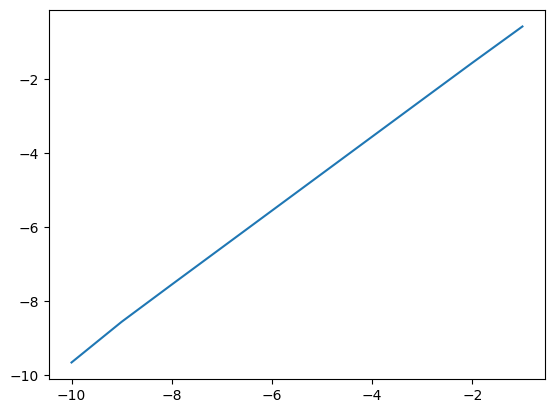

In [21]:
plt.plot(np.log10(epsilon_data), np.log10(error_div_u)) 

/tmp/jt925938/login23-g-1_109249/ipykernel_137443/3722972882.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


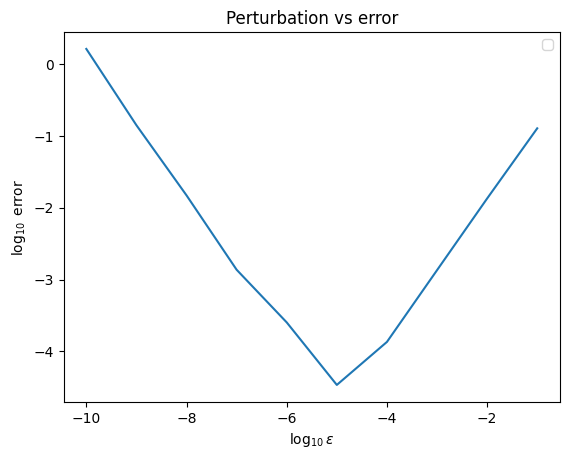

In [22]:
plt.plot(np.log10(epsilon_data), np.log10(error_data)) 
plt.xlabel("$\log_{10} \epsilon$")
plt.ylabel("$\log_{10}$ error")
plt.title("Perturbation vs error")
plt.legend()
plt.show()